In [21]:
# testing hysteresis parameter calculation? 
import numpy as np
import scipy.integrate as spi
from scipy.optimize import curve_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.collections as mcoll
import matplotlib.path as mpath

storm_directory = 'C:/Users/huck4481/Documents/GitHub/La_Jara/Hysteresis/All_Summer_Storms'
storms = {}
for filename in os.listdir(storm_directory):
    # check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(storm_directory, filename) # construct the full file path
        df = pd.read_csv(file_path)                         # read the CSV file into a data frame
        df = df.dropna(subset=['Date_Time'])                # drop rows where 'Date/Time' is NaN  
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])   # convert to datetime format
        df = df.set_index('Date_Time')                      # set date time as the index 
        df = df.dropna(how='all', axis=1)                   # drop columns where all values are NaN
        key = filename[:-4]                                 # remove the '.csv' from the filename to use as the dictionary key
        storms[key] = df                                    # store the data frame in the dictionary

## STORM 1 AS EXAMPLE ## 
SSC = np.array(storms['st1_down']['SS (uL/L)'])
Q = np.array(storms['st1_down']['depth'])

In [22]:
def normalize_data(Q, SSC):
    Qn = Q / np.max(Q)  
    SSCn = SSC / np.max(SSC) 
    return Qn, SSCn

def find_rising_falling_limb(Qn, SSCn):
    Qmax_idx = np.argmax(Qn)  # find the index of the maximum discharge (Qmax)

    # rising limb: including Qmax
    rising_Qn = Qn[:Qmax_idx+1]
    rising_SSCn = SSCn[:Qmax_idx+1]
    # falling limb: excluding Qmax
    falling_Qn = Qn[Qmax_idx:]
    falling_SSCn = SSCn[Qmax_idx:]
    return rising_Qn, rising_SSCn, falling_Qn, falling_SSCn

def distance_from_line(x, y, m, b):
    return np.abs(m * x - y + b) / np.sqrt(m**2 + 1)

def get_projection(x0, y0, m, b):
    x_proj = (x0 + m * (y0 - b)) / (1 + m**2)
    y_proj = m * x_proj + b
    return x_proj, y_proj

def check_rising_sign(x0, y0, m, b):
    C = y0 - (m * x0 + b)  # Compute signed distance
    if C >= 0:
        sign = 1
    else:
        sign =-1
    return sign

def check_falling_sign(x0, y0, m, b):
    C = y0 - (m * x0 + b)  # Compute signed distance
    if C >= 0:
        sign = -1
    else:
        sign = 1
    return sign

In [23]:
# normalize discharge and SSC
Qn, SSCn = normalize_data(Q, SSC)
# find the rising and falling limbs
rising_Qn, rising_SSCn, falling_Qn, falling_SSCn = find_rising_falling_limb(Qn, SSCn)

# interpolate to get expected values along the rising and falling limbs
rising_SSC_interp = np.interp(Qn, rising_Qn, rising_SSCn)
falling_SSC_interp = np.interp(Qn, falling_Qn, falling_SSCn)
Qmax = np.max(Qn)

# Reference line from Qmax to the last point of the loop
reference_line_x = [Qmax, Qn[-1]]  # X-coordinates (discharge)
reference_line_y = [SSCn[np.argmax(Qn == Qmax)], SSCn[-1]]  # Y-coordinates (SSC)

# Calculate the slope (m) and intercept (b) of the reference line
m = (reference_line_y[1] - reference_line_y[0]) / (reference_line_x[1] - reference_line_x[0])
b = reference_line_y[0] - m * reference_line_x[0]

# Calculate perpendicular distances from each point in rising and falling limbs to the reference line
Drise = [distance_from_line(rise_x, rise_y, m, b) for rise_x, rise_y in zip(rising_Qn[1:-1], rising_SSCn[1:-1])]
Dfall = [distance_from_line(fall_x, fall_y, m, b) for fall_x, fall_y in zip(falling_Qn[1:-1], falling_SSCn[1:-1])]

In [26]:
Drise_max = np.max(Drise)
Dfall_max = np.max(Dfall)

Drise_Qn = rising_Qn[1:-1][Drise == Drise_max]
Drise_SSCn = rising_SSCn[1:-1][Drise == Drise_max]

Dfall_Qn = falling_Qn[1:-1][Dfall == Dfall_max]
Dfall_SSCn = falling_SSCn[1:-1][Dfall == Dfall_max]

Drise_xproj, Drise_yproj = get_projection(Drise_Qn, Drise_SSCn, m, b)
Dfall_xproj, Dfall_yproj = get_projection(Dfall_Qn, Dfall_SSCn, m, b)

Drise_distance = check_rising_sign(np.array(Drise_Qn), np.array(Drise_SSCn), m, b)*Drise_max
Dfall_distance = check_falling_sign(np.array(Dfall_Qn), np.array(Dfall_SSCn), m, b)*Dfall_max

In [27]:
Dfall

[0.016851864848962603, 0.012610766864700652]

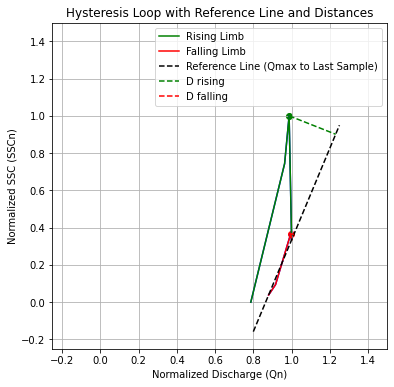

In [39]:
# Plot the hysteresis loop
plt.figure(figsize=(6, 6))
plt.plot(Qn, SSCn, color='b')
# Plot the rising and falling limbs
plt.plot(rising_Qn, rising_SSCn, label='Rising Limb', color='g')
plt.plot(falling_Qn, falling_SSCn, label='Falling Limb', color='r')
# Plot the reference line
#plt.plot(reference_line_x, reference_line_y, '--k', label='Reference Line (Qmax to Last Sample)')
tempCalc1 = np.linspace(0.8, 1.25, 100)
plt.plot(tempCalc1, m*tempCalc1 + b, '--k', label='Reference Line (Qmax to Last Sample)')
# Mark the Drise and Dfall distances
plt.plot(np.array([]), np.array([]), color="lightgreen")

# Plotting rising max
plt.scatter(Drise_Qn, Drise_SSCn, color="green")
plt.plot([Drise_Qn, Drise_xproj], [Drise_SSCn, Drise_yproj], 'g--', label="D rising")

# Plotting falling max
plt.scatter(Dfall_Qn, Dfall_SSCn, color="red")
plt.plot([Dfall_Qn, Dfall_xproj], [Dfall_SSCn, Dfall_yproj], 'r--', label="D falling")

plt.xlabel('Normalized Discharge (Qn)')
plt.ylabel('Normalized SSC (SSCn)')
plt.title('Hysteresis Loop with Reference Line and Distances')
plt.legend()
plt.xlim(-0.25,1.5)
plt.ylim(-0.25,1.5)
plt.grid(True)
plt.show()